# Deep Learning: More Recurrent Neural Networks

- Practice implementing a recurrent neural network

In [ ]:
import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, LabelField, BucketIterator
from torchtext.datasets import SST
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(12)

print(f"Pytorch version: {torch.__version__}")
print(f"Torchtext version: {torchtext.__version__}")

Pytorch version: 2.3.1.post100
Torchtext version: 0.6.0



### Note: Python must be 3.11.x

If your kernel shows a value > 3.11.x you will need to downgrade. Please email the staff for help

In [2]:
# DEVICE CONFIGURATION
if torch.backends.mps.is_available():          # Apple Silicon
    device = torch.device("mps")
elif torch.cuda.is_available():                # CUDA GPU
    device = torch.device("cuda")
else:
    device = torch.device("cpu")               # Fallback

print("Using device:", device)

Using device: mps


In [3]:
# Define field types
TEXT = Field(tokenize='basic_english', lower=True, include_lengths=True)
LABEL = LabelField(dtype=torch.float)

# Load SST data
train_data, dev_data, test_data = SST.splits(
    TEXT, LABEL, fine_grained=False
)
train_data, valid_data = train_data.split(split_ratio=0.8)

The `.splits` method is splitting up our dataset so that our train and test sets both have representative samples. 

The `fine_grained` parameter determines how many categories our data is broken into.
- if `True`: labels can be {'positive': 0, 'negative': 1, 'neutral': 2, 'very positive': 3, 'very negative': 4}
- if `False`: labels can be {'positive': 0, 'negative': 1, 'neutral': 2}

In [ ]:
# Build vocabulary
MAX_VOCAB_SIZE = 10000
TEXT.build_vocab(train_data, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

vocab = TEXT.vocab.stoi
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

### Q: What variable type is `vocab`? What does the `.build_vocab` method do?
Hint: `.stoi` stand for "string to int"!

### A: 
YOUR ANSWER HERE

In [63]:
def decode_dataset(dataset):
    # Reverse label mapping: string -> int
    label_stoi = LABEL.vocab.stoi
    texts = [example.text for example in dataset] 
    labels = [label_stoi[example.label] for example in dataset]
    return texts, labels

train_texts, train_labels = decode_dataset(train_data)
valid_texts, valid_labels = decode_dataset(valid_data)
test_texts, test_labels   = decode_dataset(test_data)

### Sanity Check 🧠 
Let's check that the decoded dataset makes sense!

In [60]:
label_map = {idx: word for word, idx in LABEL.vocab.stoi.items()}

# Change i and see what happens!
i = 0

print(" ".join(test_texts[i]))
print(label_map[test_labels[i]])

effective but too-tepid biopic
neutral


----

Now let's define a `BucketIterator`:

In [6]:
BATCH_SIZE = 32
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text),
    device=device
)

Below is a custom classifier:

In [67]:
# Custom LSTM Classifier
class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text, text_lengths):
        # text: [batch_size, seq_len] if batch_first=True
        embedded = self.embedding(text)  # [batch_size, seq_len, emb_dim]

        # Pack padded sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=False, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        # hidden: [1, batch_size, hidden_dim]  -> take the last hidden state
        return self.fc(hidden.squeeze(0))  # [batch_size, output_dim]


# Send model to device
EMBEDDING_DIM = 100
HIDDEN_DIM = 256
OUTPUT_DIM = 1

model = SimpleLSTM(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, pad_idx).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


Let's train our model!

In [66]:
# TRAINING LOOP

NUM_EPOCHS = 5
train_losses = []
train_accs = []
from tqdm import tqdm

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    # Wrap the iterator with tqdm
    for batch in tqdm(train_iterator, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        text, text_lengths = batch.text
        labels = batch.label

        text, text_lengths, labels = text.to(device), text_lengths.to(device), labels.to(device)

        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)

        # Loss
        loss = criterion(predictions, labels.float())
        loss.backward()
        optimizer.step()

        # Optional: compute accuracy
        preds = torch.round(torch.sigmoid(predictions))
        acc = (preds == labels).float().mean()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    avg_loss = epoch_loss/ len(train_iterator)
    avg_acc = epoch_acc/ len(train_iterator)
    train_losses.append(avg_loss)
    train_accs.append(avg_acc)
    print(f"Loss = {avg_loss:.4f}, Accuracy = {avg_acc:.4f}\n")


Epoch 1/5: 100%|██████████| 214/214 [00:05<00:00, 42.41it/s]


Loss = -81.1991, Accuracy = 0.7465



Epoch 2/5: 100%|██████████| 214/214 [00:05<00:00, 42.21it/s]


Loss = -89.8840, Accuracy = 0.7258



Epoch 3/5: 100%|██████████| 214/214 [00:04<00:00, 43.19it/s]


Loss = -100.9957, Accuracy = 0.7411



Epoch 4/5: 100%|██████████| 214/214 [00:05<00:00, 42.71it/s]


Loss = -112.2625, Accuracy = 0.7509



Epoch 5/5: 100%|██████████| 214/214 [00:05<00:00, 41.53it/s]

Loss = -122.5913, Accuracy = 0.7611



Quick check via plotting to verify our model learned something:

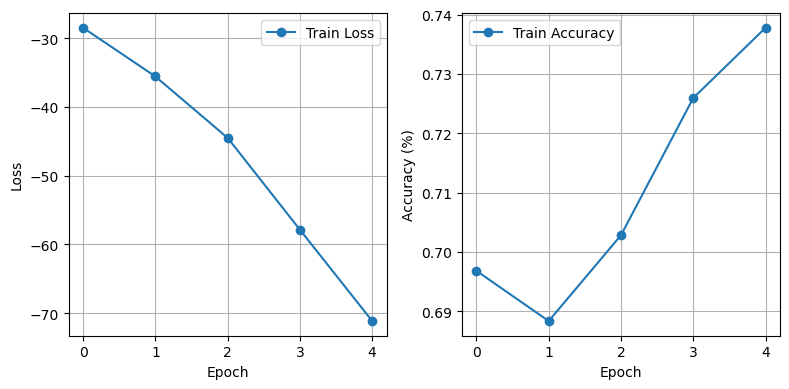

In [65]:
plt.figure(figsize=(8,4), tight_layout=True)
plt.subplot(1,2,1)
plt.plot(train_losses, "-o", label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, "-o", label="Train Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid()
plt.legend()
plt.show()


### Q: Try changing the value in `torch.manual_seed()`. What happens to the train loss and accuracy plots? What does this tell us about the impact of the initial guess (i.e. epoch 0)?

Note: `torch.manual_seed()` is at the top of this notebook!

### A: 
YOUR ANSWER HERE

----

Finally, let's check that our model can generalize by processing the test data:

In [32]:
# Evaluate on test set
model.eval()
test_loss, test_acc, = 0,0

with torch.no_grad():
    for batch in test_iterator:
        text, text_lengths = batch.text
        labels = batch.label

        text = text.to(device)
        text_lengths = text_lengths.to(device)
        labels = labels.to(device)

        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, labels.float())

        preds = torch.round(torch.sigmoid(predictions))
        acc = (preds == labels).float().mean()

        test_loss += loss.item()
        test_acc += acc.item()

print(f"Test Accuracy: {100 * test_acc / len(test_iterator):.2f}%")

Test Accuracy: 56.43%


----
## Further Exploration 🔎

### Q: What happens to the test accuracy as `torch.manual_seed()` is changed? What does this tell us about our neural network?

### A:
YOUR ANSWER HERE

### Q: What happens to your results if you set `find_grained=True`?
Try to predict first and then test your hypothesis by changing the value and re-running!

### A: 
YOUR ANSWER HERE